###Deep Learning Final Project: Keras NLP Article Classification

This data comes from a previous course I took: Supervised Text Analytics. In this class, the goal was to use KTrain (another keras related library) to be able to predict when an article was health related based on title and body of the article

The purpose of reusing this data is to see if I can use Natural Language Processing using Keras to be able to predict multiple article types rather than just the one. Natural Language Processing has always interested me as there is so much that can be done, including translating, classifying, etc using this.

https://github.com/MichaelButlerDS/Article-Classification-

Install and load Dependencies

In [1]:
!pip install nlp
!pip install wordcloud


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import pandas as pd
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Mount google drive and read in the data.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
raw_data = pd.read_json("drive/MyDrive/news_category_trainingdata.json")

In [110]:
data = raw_data

Look at the records and types within the data.

In [63]:
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [111]:
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ MB
None
(200853, 6)


Remove date, link, and authors from the data.

In [65]:
data = data.drop(['link', 'date', 'authors'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200853 entries, 0 to 200852
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   short_description  200853 non-null  object
dtypes: object(3)
memory usage: 6.1+ MB


Show how many of each category is in the dataset.

In [66]:
category_counts = data['category'].value_counts()
print(category_counts)

category
POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: c

Create a word cloud of the categories, to show the quantity of each and the most relevant ones.

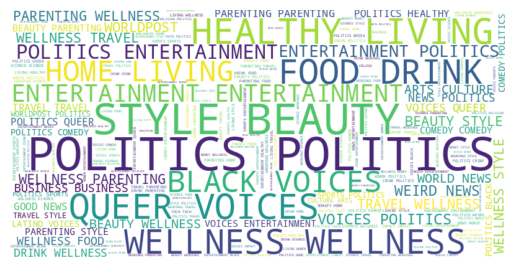

In [67]:
Categories = list(data['category'])
Categories = ' '.join(Categories)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(Categories)
plot = plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Only keeping the top 6 categories so there are not too many options. Graphed these and the number of articles per category

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'POLITICS'),
  Text(1, 0, 'WELLNESS'),
  Text(2, 0, 'ENTERTAINMENT'),
  Text(3, 0, 'TRAVEL'),
  Text(4, 0, 'STYLE & BEAUTY'),
  Text(5, 0, 'PARENTING')])

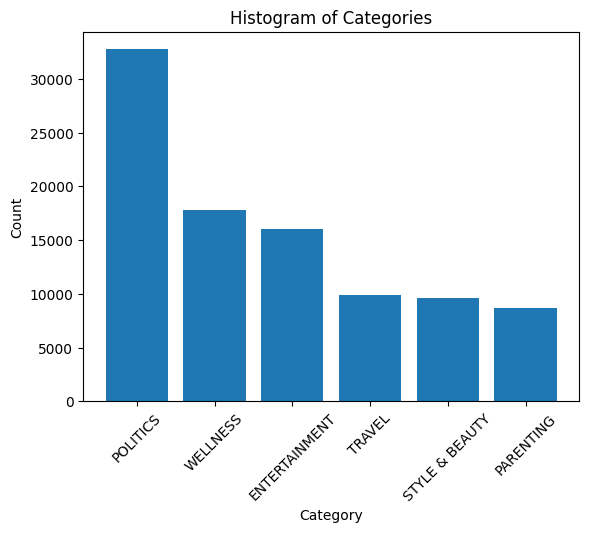

In [106]:
top_categories = category_counts.head(6).index
data = data[data['category'].isin(top_categories)]
category_counts = data['category'].value_counts()
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Histogram of Categories')
plt.xticks(rotation=45)

Split data into Training, Validation, and Test sets. Limiting to 5000 of each category to reduce size of data.

This did not work as there was not enough data, the accuracy was coming up as NaN for the test data. Once adding the data back in, the model performed very well.

In [83]:
def sample_category(group):
    return group.sample(min(len(group), 5000))

#reduced_data = data.groupby('category', group_keys=False).apply(sample_category)
#reduced_data.reset_index(drop=True, inplace=True)
#reduced_data.info()
reduced_data = data

Combine Headline and Short Description

In [84]:
reduced_data['text'] = reduced_data['headline'] + ' ' + reduced_data['short_description']
reduced_data['text'][1]

"Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song Of course it has a song."

Remove numbers from the text.

In [85]:
reduced_data['text'] = reduced_data['text'].str.replace('\d+', '', regex=True)
reduced_data['text'] = reduced_data['text'].str.lower()

In [86]:
Val_num = int(.1 * len(reduced_data))
Val_num
shuffled_data = reduced_data.sample(frac=1).reset_index(drop=True)
Train_num = len(reduced_data) - Val_num*2
print(Train_num)
train = reduced_data[:Train_num]
val = reduced_data[Train_num:Train_num+Val_num]
test = reduced_data[Train_num+Val_num:]

75871


Tokenize and print example of text and the tokenized text.

In [87]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>', split = ' ', lower=True)
tokenizer.fit_on_texts(train['text'])
print(train['text'][1])
print(tokenizer.texts_to_sequences(train['text'])[1])

will smith joins diplo and nicky jam for the  world cup's official song of course it has a song.
[3652, 5255, 8070, 9, 2, 75, 58, 21, 454, 2, 599, 6, 35, 4148, 3134, 2431, 1, 2730, 2, 8357, 7, 4, 840, 2654]


Sample of the tokenized texts.

In [88]:
list(tokenizer.word_index)[0:5]

['<UNK>', 'the', 'to', 'a', 'of']

In [89]:
maxlen=50
def get_sequences(tokenizer, text):
  sequences = tokenizer.texts_to_sequences(text)
  padded = pad_sequences(sequences, truncating = 'post', padding='post', maxlen=maxlen)
  return padded
padded_train = get_sequences(tokenizer, train['text'])

In [90]:
labels = train['category']
classes = set(labels)
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)

In [91]:
print(class_to_index)
print(index_to_class)

{'WELLNESS': 0, 'TRAVEL': 1, 'ENTERTAINMENT': 2, 'PARENTING': 3, 'POLITICS': 4, 'STYLE & BEAUTY': 5}
{0: 'WELLNESS', 1: 'TRAVEL', 2: 'ENTERTAINMENT', 3: 'PARENTING', 4: 'POLITICS', 5: 'STYLE & BEAUTY'}


Building the model

In [92]:
def create_model(vocab_size, embedding_dim, maxlen):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')])
    return model
def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

In [93]:
model = create_model(10000, 16, maxlen)
compile_model(model)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_8 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
padded_train

array([[  39, 1590, 2306, ...,    0,    0,    0],
       [3652, 5255, 8070, ...,    0,    0,    0],
       [1917, 7583, 3003, ...,    0,    0,    0],
       ...,
       [  48,  216, 4467, ...,    0,    0,    0],
       [ 168,  935, 6556, ...,    0,    0,    0],
       [8945, 1246,    2, ...,    0,    0,    0]], dtype=int32)

In [95]:
padded_val = get_sequences(tokenizer, val['text'])
val_labels = names_to_ids(val['category'])
padded_train = padded_train.astype('float32')
train_labels = train_labels.astype('float32')
padded_val = padded_val.astype('float32')
val_labels = val_labels.astype('float32')
h = model.fit(
    padded_train, train_labels,
    validation_data=(padded_val, val_labels),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/20
2371/2371 [==============================] - 53s 20ms/step - loss: 0.5678 - accuracy: 0.8021 - val_loss: 0.6145 - val_accuracy: 0.7982
Epoch 2/20
2371/2371 [==============================] - 35s 15ms/step - loss: 0.2882 - accuracy: 0.9082 - val_loss: 0.5773 - val_accuracy: 0.8196
Epoch 3/20
2371/2371 [==============================] - 33s 14ms/step - loss: 0.2238 - accuracy: 0.9296 - val_loss: 0.6227 - val_accuracy: 0.8077
Epoch 4/20
2371/2371 [==============================] - 32s 14ms/step - loss: 0.1821 - accuracy: 0.9434 - val_loss: 0.6354 - val_accuracy: 0.8128


In [96]:
padded_test = get_sequences(tokenizer, test['text'])
test_labels = names_to_ids(test['category'])
padded_test = padded_test.astype('float32')
test_labels = test_labels.astype('float32')
model.evaluate(padded_test, test_labels)

297/297 [==============================] - 2s 6ms/step - loss: 0.5856 - accuracy: 0.8215


[0.5855662822723389, 0.8214700222015381]

Graphing the accuracy vs the val_accuracy shows that the accuracy of validation was consistent compared to the training data.

<ipython-input-101-44cfad9d0482>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy', color = "red")


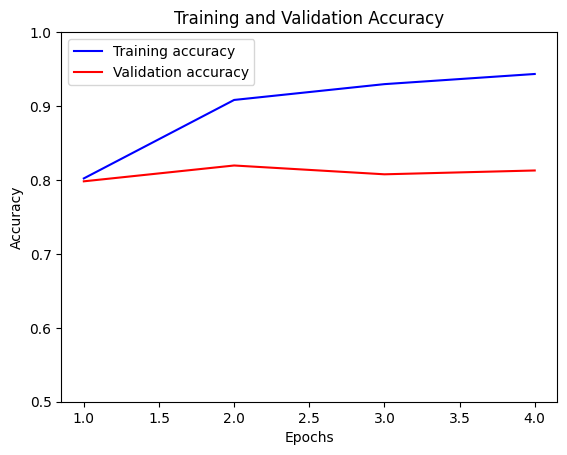

In [101]:
accuracy = h.history['accuracy']
val_accuracy = h.history['val_accuracy']

# Plot accuracy and validation accuracy
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy', color = "red")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylim(0.5, 1)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###Conclusion
This was a great project for me, because as I continued to learn through the courses, I was able to learn more and be able to create a model that rivals one I was previously guided through as well as predicting 5 categories, rather an 1. I ran into a number of issues with creating the model which are as follows:

The tokenizer was tokenizing every single letter rather than words. The way I was able to fix this issue was to input the whole set of data rather than just the one text string.

The next issue I ran into was with the model itself. I had to restrict the data to 5 categories as I was unable to diagnose what parameter I had to change to predict all categories. I also had an issue with the datatypes not being correct. I ended up having to change all of my inputs into float32 values, which fixed the issue.

The last issue I ran into was that I was getting a NaN accuracy for my test data. I figured out I was limiting the data options, so once I added back in all the data for the 5 categories I was more successful and produced an accuracy of ~80%.

In all, this was a great learning opportunity and has sparked an interest in continue learning about Keras and machine learning. A few ways I may improve this model in the future include:


*   Fine tune the hyperparameters more.
*   Include more categories once I fix my issue
*   Add in other article data from different sources

